In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import plot_importance, XGBClassifier
from category_encoders import TargetEncoder

# stopping frustrating warnings that didn't say much
import warnings
warnings.filterwarnings("ignore")

In [3]:
def classify_to_indications(y: np.array)-> np.array:
    def classify_to_indication(number: float) -> str:
        if number < 12:
            return 'dagdeel'
        if number < 24:
            return '24 uur'
        if number < 48:
            return '2 dagen'
        if number < 96:
            return '4 dagen'
        else:
            return '4 dagen <'
        
    return np.vectorize(classify_to_indication)(y)

In [17]:
def split_and_target_encoding(uncopied_X: pd.DataFrame, columns_to_be_encoded: list[str], target_column: str, test_size: float) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    X = uncopied_X.copy()
    y = X.pop(target_column)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    encoder = TargetEncoder(cols=columns_to_be_encoded)
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_test_encoded = encoder.transform(X_test)

    return X_train_encoded, y_train, X_test_encoded, y_test

In [54]:
X = pd.read_csv(r'alle_kranten_ongesplitst.csv', delimiter=',')

X_train, y_train, X_test, y_test = split_and_target_encoding(X, ['author_ids', 'main_section', 'subsections_labels', 'brand'], 'relevance_window_in_hours', 0.2)

# put into buckets
y_train = classify_to_indications(y_train)
y_test = classify_to_indications(y_test)

# convert buckets to numbers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

211578     10.0
47373      29.0
154081     12.0
153156    316.0
174831      6.0
          ...  
180265     12.0
106737     47.0
135294     21.0
18120       9.0
57702      27.0
Name: relevance_window_in_hours, Length: 170772, dtype: float64


In [33]:
# find the weights of the classes so they are more balanced
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [45]:
# used the hyperparameters found below
model = XGBClassifier(objective='multi:softprob', 
                      num_class= 5, 
                      eval_metric='mlogloss', 
                      learning_rate= 0.1, 
                      max_depth= 8, 
                      n_estimators = 200, 
                      early_stopping_rounds=20, 
                      subsample = 1, 
                      colsample_bytree=1,
                      scale_pos_weight = class_weights.tolist(),
                      L1=0,
                      L2=1)

In [46]:
eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-mlogloss:1.54749	validation_1-mlogloss:1.55505
[1]	validation_0-mlogloss:1.49424	validation_1-mlogloss:1.50829
[2]	validation_0-mlogloss:1.44840	validation_1-mlogloss:1.46841
[3]	validation_0-mlogloss:1.40787	validation_1-mlogloss:1.43337
[4]	validation_0-mlogloss:1.37212	validation_1-mlogloss:1.40313
[5]	validation_0-mlogloss:1.34032	validation_1-mlogloss:1.37615
[6]	validation_0-mlogloss:1.31151	validation_1-mlogloss:1.35201
[7]	validation_0-mlogloss:1.28610	validation_1-mlogloss:1.33105
[8]	validation_0-mlogloss:1.26278	validation_1-mlogloss:1.31219
[9]	validation_0-mlogloss:1.24207	validation_1-mlogloss:1.29559
[10]	validation_0-mlogloss:1.22267	validation_1-mlogloss:1.28033
[11]	validation_0-mlogloss:1.20471	validation_1-mlogloss:1.26630
[12]	validation_0-mlogloss:1.18896	validation_1-mlogloss:1.25409
[13]	validation_0-mlogloss:1.17418	validation_1-mlogloss:1.24300
[14]	validation_0-mlogloss:1.16010	validation_1-mlogloss:1.23278
[15]	validation_0-mlogloss:1.14723	

XGBClassifier(L1=0, L2=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=20, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [43]:
"""
Takes a really long time! Not for running just because
"""

# Columns that need target encoding
categorical_columns = ['author_ids', 'main_section', 'subsections_labels', 'brand']

# Use new dataset so cross validation can be done correctly with target encoding
X = pd.read_csv(r'alle_kranten_ongesplitst.csv', delimiter=',')
y = X.pop('relevance_window_in_hours')

X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X,y, test_size=0.2)

# Create a pipeline with targetencoding included, so the cross validation doesn't have leaking info
pipeline = Pipeline(steps=[
    ('target_encoder', ColumnTransformer(
        transformers=[
            ('cat', TargetEncoder(), categorical_columns)
        ],
        remainder='passthrough'  
    )),
    ('model', XGBClassifier(objective='multi:softmax', 
                                num_class= 5, 
                                min_child_weight=1, 
                                gamma=0.1, 
                                eval_metric='mlogloss', 
                                subsample = 1.0, 
                                colsample_bytree=0.8,
                                scale_pos_weight = class_weights.tolist()))  # XGBoost model
])

param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 200}
Best Score: 0.5843112613995902
Test Set Accuracy: 0.5546446807513936


learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8

In [ ]:

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 1 = '2 dagen'
# 2 = '24 uur'
# 3 = '4 dagen'
# 4 = 'Dagdeel'
# 5 = 'Langer dan 4 dagen'

              precision    recall  f1-score   support

           0       0.51      0.69      0.59     15115
           1       0.61      0.63      0.62     14240
           2       0.45      0.18      0.26      5801
           3       0.58      0.36      0.44      3250
           4       0.63      0.49      0.55      4288

    accuracy                           0.55     42694
   macro avg       0.56      0.47      0.49     42694
weighted avg       0.55      0.55      0.54     42694



[]

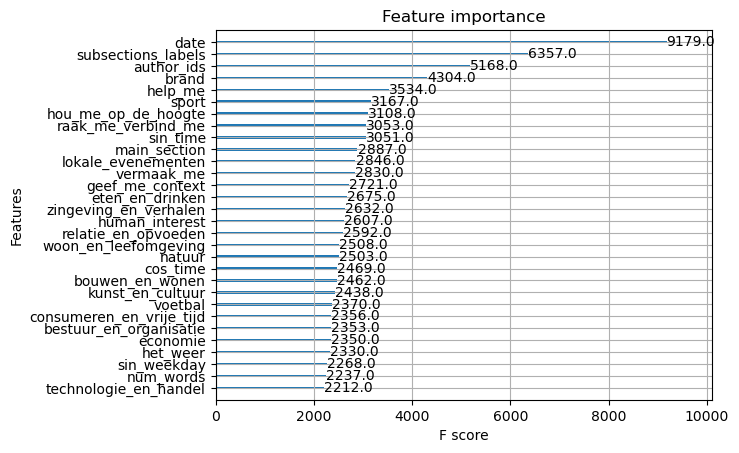

In [52]:
# only 30 highest because of readability
plot_importance(model, max_num_features=30)
plt.plot()